### ok lets play with out new ideas

we could add a dimension, change the layers etc

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

context_length = 5

In [2]:
with open("names.txt", "r") as r:
    names = ["." + f + "." for f in r.read().split()]

import string
letters = [l for l in string.ascii_lowercase]

itos = {0: "."}
stoi = {".": 0}

for i, l in enumerate(letters):
    offset = i+1
    stoi[l] = offset
    itos[offset] = l


In [3]:
import random
from random import randrange

In [15]:
def word_contexts(word):
    samples = []
    max_length = len(word)
    fill = '.' * context_length
    for i in range(1,max_length):
        st = max(0, i-context_length)
        filled = fill[i:] + word[st:i]
        samples.append(filled[:context_length])
    return samples
word_contexts(".timothy.")

['.....', '....t', '...ti', '..tim', '.timo', 'timot', 'imoth', 'mothy']

In [5]:
def get_xys(samples):
    xs, ys = [], []
    for s in samples:
        for ctx in word_contexts(s):
            x =  [stoi[c] for c in ctx]
            xs.append(x)
        y = [stoi[c] for c in s[1:]]
        ys += y

    return xs, ys

In [19]:
get_xys(names[:2])

([[0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1],
  [0, 0, 0, 1, 13],
  [0, 0, 1, 13, 25],
  [0, 1, 13, 25, 1],
  [1, 13, 25, 1, 8],
  [0, 0, 0, 0, 0],
  [0, 0, 0, 0, 26],
  [0, 0, 0, 26, 1],
  [0, 0, 26, 1, 13],
  [0, 26, 1, 13, 15],
  [26, 1, 13, 15, 18],
  [1, 13, 15, 18, 1]],
 [1, 13, 25, 1, 8, 0, 26, 1, 13, 15, 18, 1, 0])

In [6]:
## better sample with train/dev/test split
import math
# shuffle names
from random import shuffle

shuffle(names)

x_names, y_names = get_xys(names)
samples_length = len(y_names)
train_length = math.floor(samples_length * .8)
dev_offset = math.floor(samples_length * .9)

dev = list(zip(x_names[train_length: dev_offset], y_names[train_length: dev_offset]))
test = list(zip(x_names[dev_offset:], y_names[dev_offset:]))

train = list(zip(x_names[:train_length], y_names[:train_length]))

def sample_names(sample_size = 5, p = train):
    samples = random.sample(p, sample_size)
    x_samples = [s[0] for s in samples]
    y_samples = [s[1] for s in samples]
    return x_samples, y_samples

## apply the 'magic numbers'

In [7]:
dimsb = 9
nonlin='relu'
# one slightly weird thing in makemore pt3 is that he only explains using a non-liniarity as a very short aside near the end.

In [35]:
hidden_layer_size = 200

esb = torch.randn((27, dimsb))
W1b = torch.randn((dimsb*context_length, hidden_layer_size))

b1b = torch.randn(hidden_layer_size) * 0.001

W2b = torch.randn((hidden_layer_size, 27)) / (dimsb*context_length)**0.5
b2b = torch.randn(27) * 0.001

# initialization
nn.init.kaiming_normal_(W1b, nonlinearity=nonlin)

# magic numbers
W1b = W1b * 3/5
# make output less confident
W2b = W2b * .5

parametersb = [esb, W1b, b1b, W2b, b2b]
for p in parametersb:
    p.requires_grad=True

In [36]:
names_length = len(names)
epochs = 80
batch_size = 200
learning_rate = .1
sample_loops = 800

In [37]:
running_loss = []
running_lr = []

histograms_w1 = []
histograms_w2 = []

lr_step = { 80: .01, 121: .001}
lr_step_9 = { 100: .02, 161: .004}

trainable_parameters = sum(p.numel() for p in parametersb)

ud_ratio = []
lud_ratio = []

trainable_parameters

14870

In [38]:
for ep in range(epochs):
    epoch_loss = 0
    for s in range(sample_loops):
        x, y = sample_names(batch_size)
        Y = torch.tensor(y)
        train = esb[x]

        preact = train.view(-1, dimsb * context_length) @ W1b + b1b
        # add learnable normalization?
        # preact = (preact - preact.mean(0, keepdim=True))/preact.std(0, keepdim=True)
        
        if nonlin == 'relu':
            outputL1 = torch.relu(preact)
        else:
            outputL1 = torch.tanh(preact)
        
        logits = outputL1 @ W2b + b2b

        lossb = F.cross_entropy(logits, Y)

        with torch.no_grad():
            epoch_loss += lossb

        for p in parametersb:
            p.grad = None
        
        lossb.backward()

        for p in parametersb:
            p.data -= learning_rate * p.grad

    #just keep any epoch stuff in a no grad block
    with torch.no_grad():
        if ep in lr_step_9:
            learning_rate = lr_step_9[ep]
    
        running_loss.append(epoch_loss.item())
        running_lr.append(learning_rate)
     
        histograms_w1.append(W1b.detach())
        histograms_w2.append(W2b.detach())

        lud_ratio.append([ (learning_rate*p.grad.std()/ p.data.std()).log().item() for p in parametersb ])
        ud_ratio.append([ (learning_rate*p.grad.std()/ p.data.std()).log10().item() for p in parametersb ])
    
        if ep % 10 == 0:
            print(epoch_loss/sample_loops)
            learning_rate *= .92
            print(ep, learning_rate)

tensor(2.4625)
0 0.09200000000000001
tensor(2.1032)
10 0.08464000000000002
tensor(2.0505)
20 0.07786880000000002
tensor(2.0321)
30 0.07163929600000002
tensor(2.0086)
40 0.06590815232000002
tensor(1.9980)
50 0.06063550013440003
tensor(1.9900)
60 0.05578466012364803
tensor(1.9811)
70 0.05132188731375619


In [93]:
dev_x = [s[0] for s in dev]
dev_y = torch.tensor([s[1] for s in dev])
val = esb[dev_x]
val1 = torch.relu(val.view(-1, dimsb * context_length) @ W1b + b1b)

val_logits = val1 @ W2b + b2b

val_loss = F.cross_entropy(val_logits, dev_y)
val_loss

tensor(2.0488, grad_fn=<NllLossBackward0>)

some train/val losses

5 dims:             (trainable_paramters: 10762)
*  2.0117 / 2.0601 
*  2.0171 / 2.0676 (no gain / magic numbers)
*  2.0917 / 2.1234 (no initialization)

5 dim:              (trainable_paramters: 12882 - up from 200 to 240 in nl layer)
 * with initialization, and gain  -  and more parameters the model achieved > 5 dims above within 10 of our 'epochs'
 * 1.9941 / 2.0587

6 dims:             (trainable_parameters: 11789
* 1.9901 / 2.0439

  - so 6 dims improved over 5 even with less trainable parameters
  
6 dims:             (trainable_parameters: 14109)
* 1.9796 / 2.0482

7 dims:             (200 relu layer)
* 1.9738 / 2.0405

7 dims:             (15336)
* 1.9519 / 2.0323

note here, no actual improvement in validation

8 dims:             (16563)
* 1.9423 / 2.0372

8 dims: 
* 1.9558 / 2.0368 8 dims

9 dims: (200 tanh layer - 14870 params so trainable params back to 6 dim level with 240 relu layer)
* 1.9266 / 2.0506

9 dims: (200 relu layer - 14870 params so trainable params back to 6 dim level with 240 relu layer)
* 1.9395 / 2.0488

increasing the params has little effect on the train/val
9 dims: (240 relu - 17790)
* 1.9205 / 2.0429


In [14]:
import matplotlib.pyplot as plt

In [27]:
outputL1.shape, W1b.shape

(torch.Size([820, 240]), torch.Size([40, 240]))

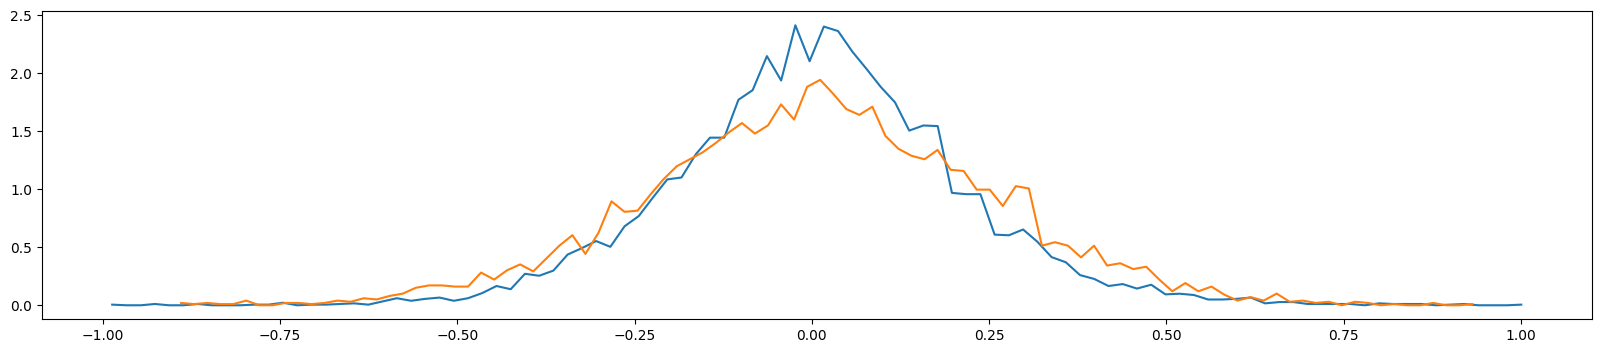

In [94]:
# look at our weight distributions

t = W1b.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = W2b.detach()
h2y, h2x = torch.histogram(t2, density=True)
plt.plot(h2x.detach()[1:], h2y.detach())

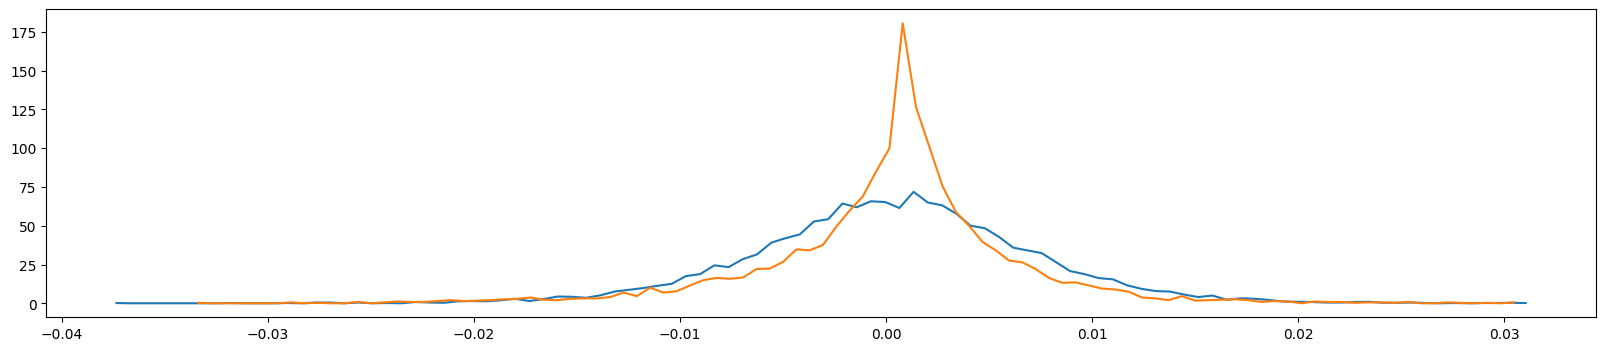

In [95]:
# look at our gradient distributions

t = W1b.grad.detach()
hy, hx = torch.histogram(t, density=True)
plt.figure(figsize=(20,4))
plt.plot(hx.detach()[1:], hy.detach())
t2 = W2b.grad.detach()
h2y, h2x = torch.histogram(t2, density=True)
plt.plot(h2x.detach()[1:], h2y.detach())

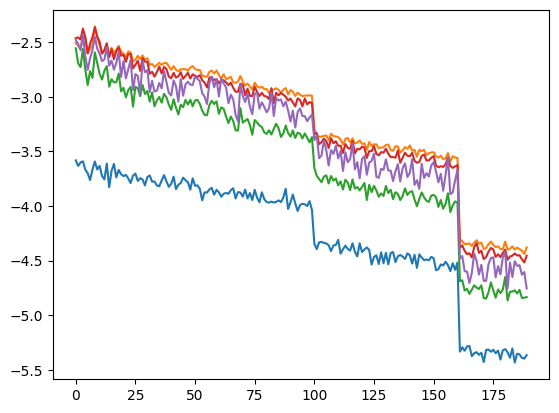

In [82]:
# 9dim 200 tanh 
plt.plot(ud_ratio)

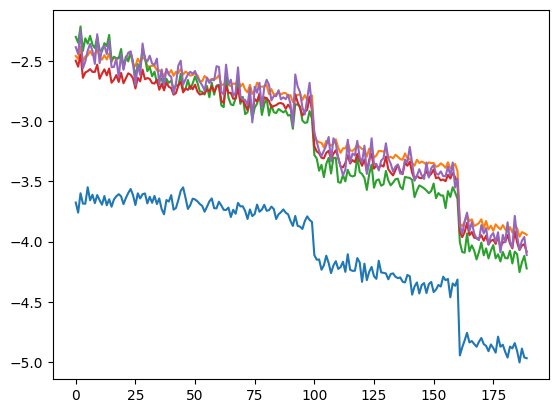

In [97]:
# 9dim 200 relu 
plt.plot(ud_ratio)

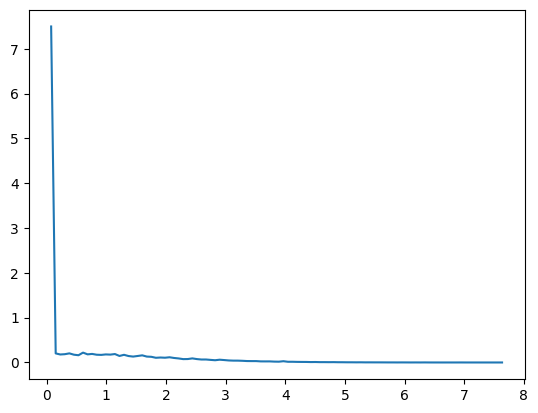

In [99]:
# the relu shape is obviously very different than a tanh

t = outputL1
hy, hx = torch.histogram(t, density=True)
plt.plot(hx.detach()[1:], hy.detach())

(tensor(0.8667, grad_fn=<StdBackward0>),
 tensor(-0.0299, grad_fn=<MeanBackward0>))

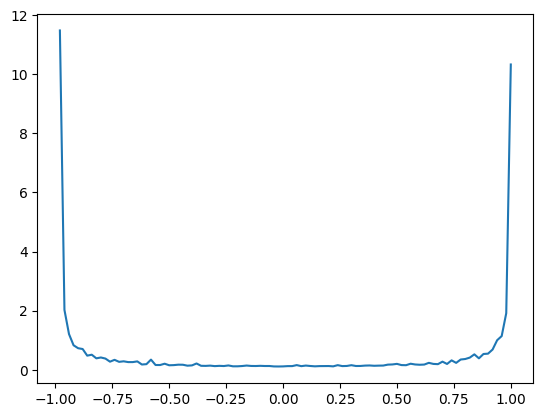

In [86]:
# the tanh activation for comparison

t = outputL1
hy, hx = torch.histogram(t, density=True)
plt.plot(hx.detach()[1:], hy.detach())

t.std(), t.mean()

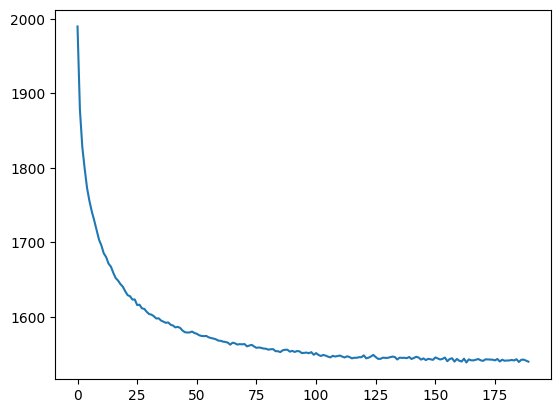

In [76]:
# 9 dims 200 tanh
eps = [i for i in range(190)]
ls = [l for l in running_loss]

plt.plot(eps, ls)

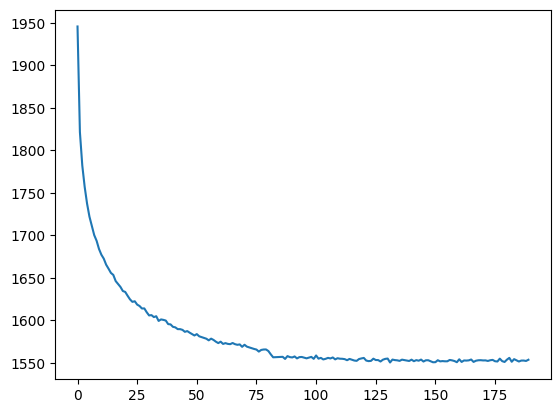

In [16]:
# 8 dims 240
eps = [i for i in range(190)]
ls = [l for l in running_loss]

plt.plot(eps, ls)

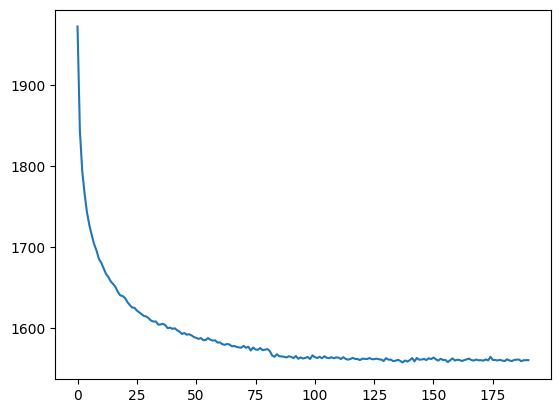

In [151]:
# 7 dims 240
eps = [i for i in range(191)]
ls = [l for l in running_loss]

plt.plot(eps, ls)

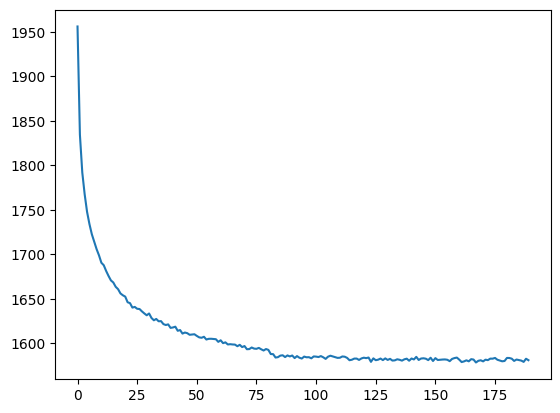

In [131]:
# 6 dims 240
eps = [i for i in range(190)]
ls = [l.item() for l in running_loss]
running_loss[0].item()

plt.plot(eps, ls)

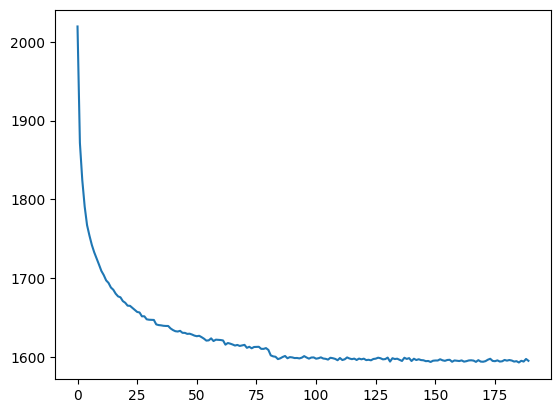

In [120]:
# 5 dims 220
eps = [i for i in range(190)]
ls = [l.item() for l in running_loss]
running_loss[0].item()

plt.plot(eps, ls)

investigate the (in this case relu) non linearity 

we're looking for zero activations for a neuron

the neurons run along the y axis (here we have 200) so the activations for a given neuron form a vertical line

maybe I'm not understanding this but a 0 activation is fine - we're just worried about 'dead' neurons which would be more like a solid vertical black line - as long as we don't have that we're fine right?

In [18]:
from ipywidgets import interact

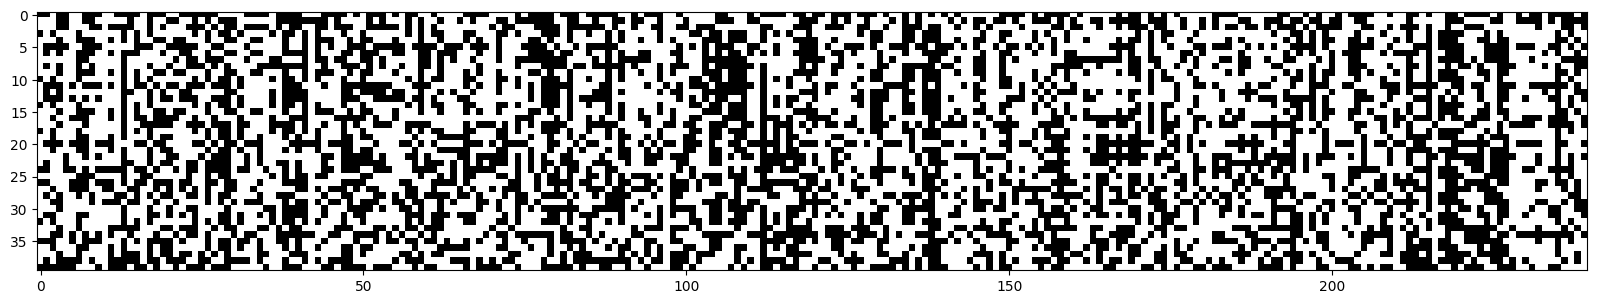

In [60]:
plt.figure(figsize=(20,10))
plt.imshow(outputL1[:40]==0, cmap='gray', interpolation='nearest')

Lets look at the weights - because the input @ the weights then goes through the relu and that's what forms the grad in the backwards pass

40


(torch.Size([40, 5, 8]),
 torch.Size([40, 40]),
 torch.Size([40, 5]),
 torch.Size([27, 8]),
 torch.Size([40, 200]),
 torch.Size([40, 200]))

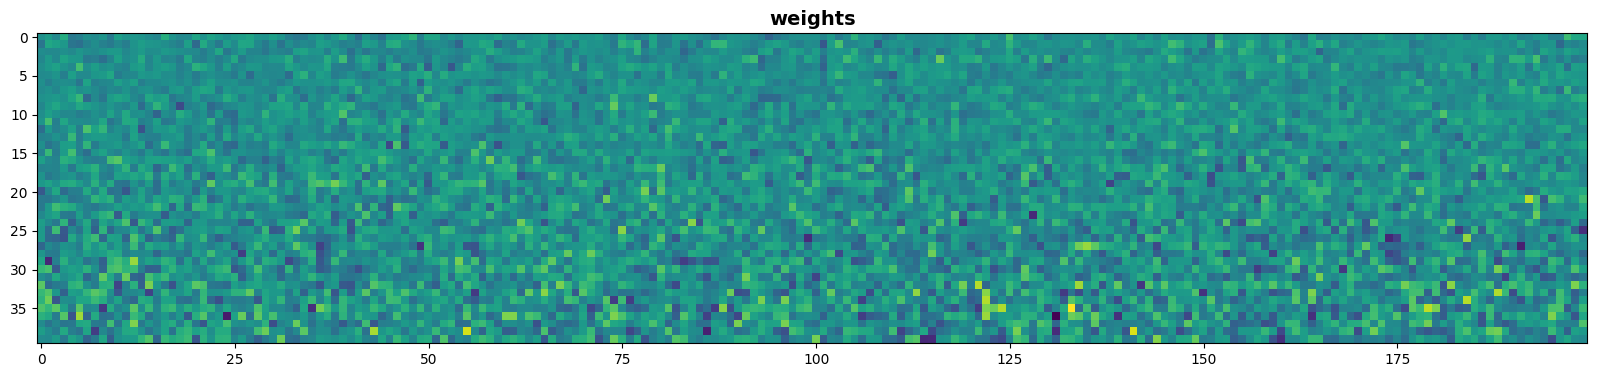

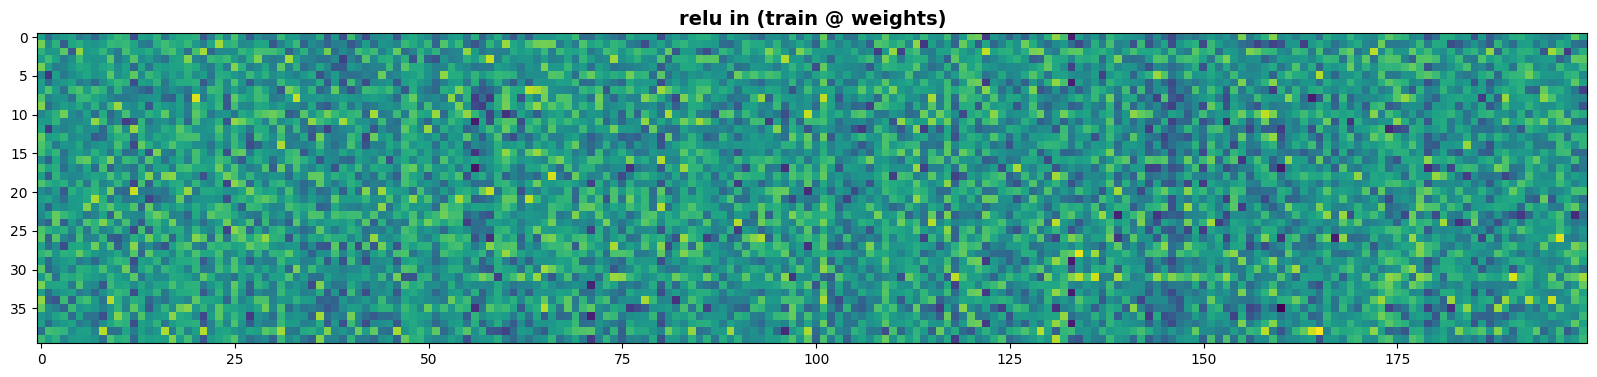

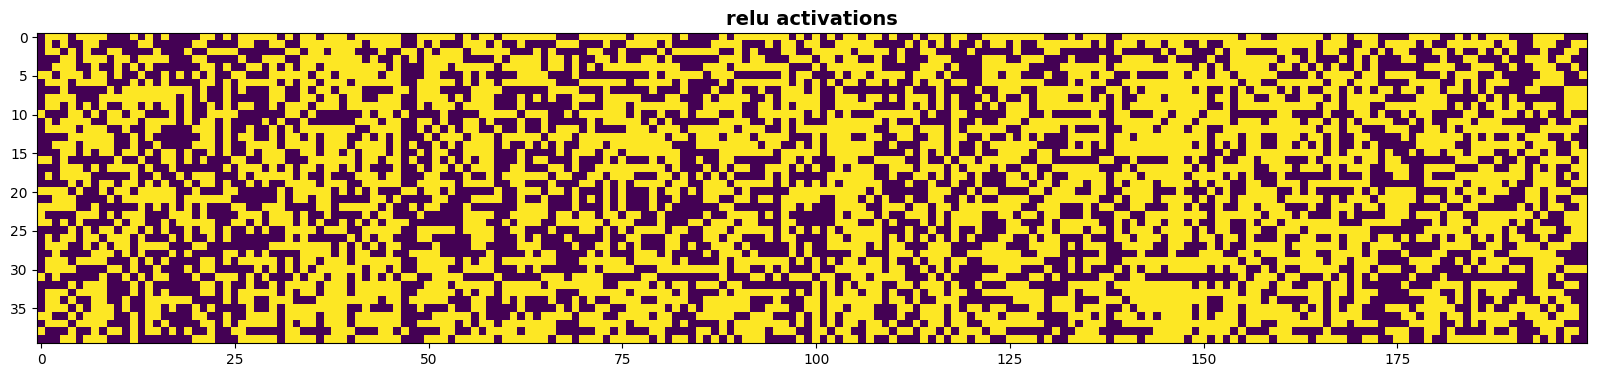

In [57]:
plt.figure(figsize=(20,10))
plt.title("weights", fontsize=14, fontweight='bold')
plt.imshow(W1b.detach().numpy())

xp, yp = sample_names(40)
# our dimensions are dimsb = 7 so trainp should have 40, dimsb, context_length
print(dimsb*context_length)
trainp = esb[xp]
# reshape (view) train by 'squishing', dimsb, context_length to dimsh * context_length
tv = trainp.view(-1, dimsb * context_length)

relu_in = tv @ W1b

plt.figure(figsize=(20,10))
plt.title("relu in (train @ weights)", fontsize=14, fontweight='bold')
plt.imshow(relu_in.detach().numpy())

relu_out = torch.relu(relu_in)
plt.figure(figsize=(20,10))
plt.title("relu activations", fontsize=14, fontweight='bold')
plt.imshow(relu_out==0)

trainp.shape, tv.shape, torch.tensor(xp).shape, esb.shape, W1b.shape, relu_in.shape

In [50]:
def generate_namesb(num_names):
    for i in range(num_names):
        out = []
        ix = [0, 0, 0, 0, 0]
        for nl in range(10):
            xenc = esb[ix]

            outputL1 = torch.relu(xenc.view(-1, dimsb * context_length) @ W1b + b1b)
            logits = outputL1 @ W2b + b2b
            
            p = F.softmax(logits, dim=1)
    
            # ## torch.multinomial pulls out an index in p (num_samples=1) by sampling from the elements in p according to their probabilities 
            # ## (p is normalized in the softmax above)
            prediction = torch.multinomial(p, num_samples=1).item()
            
            ix = [ix[1], ix[2], ix[3], ix[4], prediction]

            if prediction == 0:
                break
            out.append(itos[prediction])
            
        print("".join(out))

generate_namesb(1)

tremson


In [59]:
generate_namesb(15)

alizah
rakie
neva
pipb
jhozley
kentla
farra
aphaveelyn
kadra
ryn
masx
dekacee
alson
kartyn
helene


In [78]:
n = letters

def interactive_plot(elev, azim, zoom, dim1, dim2, dim3):

    x = esb[1:].T[dim1].tolist()
    y = esb[1:].T[dim2].tolist()
    z = esb[1:].T[dim3].tolist()
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.view_init(elev, azim)
    ax.set_box_aspect((1, 1, 1), zoom=zoom)
    
    ax.scatter(x, y, z)
    
    for i, txt in enumerate(n):
        # ax.annotate(txt, (x[i], y[i], z[i]))
        ax.text(x[i], y[i], z[i], txt, color='blue')


interact(interactive_plot, elev=(1, 45, 0.1), azim=(1, 70, 0.1), zoom=(0, 4, 0.01),  dim1=(0, 4, 1), dim2=(1, 6, 2), dim3=(1, 9, 2))

interactive(children=(FloatSlider(value=23.0, description='elev', max=45.0, min=1.0), FloatSlider(value=35.0, …

<function __main__.interactive_plot(elev, azim, zoom, dim1, dim2, dim3)>

In [40]:
n = letters

def interactive_plot(elev, azim, zoom, dim1, dim2, dim3):

    x = esb[1:].T[dim1].tolist()
    y = esb[1:].T[dim2].tolist()
    z = esb[1:].T[dim3].tolist()
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    ax.view_init(elev, azim)
    ax.set_box_aspect((1, 1, 1), zoom=zoom)
    
    ax.scatter(x, y, z)
    
    for i, txt in enumerate(n):
        # ax.annotate(txt, (x[i], y[i], z[i]))
        ax.text(x[i], y[i], z[i], txt, color='blue')


interact(interactive_plot, elev=(1, 45, 0.1), azim=(1, 70, 0.1), zoom=(0, 4, 0.01),  dim1=(0, 4, 1), dim2=(1, 6, 2), dim3=(1, 9, 2))

interactive(children=(FloatSlider(value=23.0, description='elev', max=45.0, min=1.0), FloatSlider(value=35.0, …

<function __main__.interactive_plot(elev, azim, zoom, dim1, dim2, dim3)>

Just by eye-balling 10 dimensions this way it looks like some are pretty similar 
- maybe we're not getting much from them in this simple space
- reduce and try again

7 Dimensions looks good and we get a similar loss/val - again indicating those extra dimensions are maybe starting to add less abovr 7